In [1]:
%pylab qt
import scipy.integrate as integrate
from IPython import display 

Populating the interactive namespace from numpy and matplotlib


In [16]:
# use solve_ivp to find solution from t0=0 up to a max tf (definec on next cell), but stop if x hits x=20.0

diff_n = 5
diffs = logspace(-3,2, diff_n,base = 2)
a0_n = 3
a0s = logspace(0,2,a0_n,base = 2)


# define domain and lattice
length = 30.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0s,diffs


(array([1., 2., 4.]),
 array([0.125     , 0.29730178, 0.70710678, 1.68179283, 4.        ]))

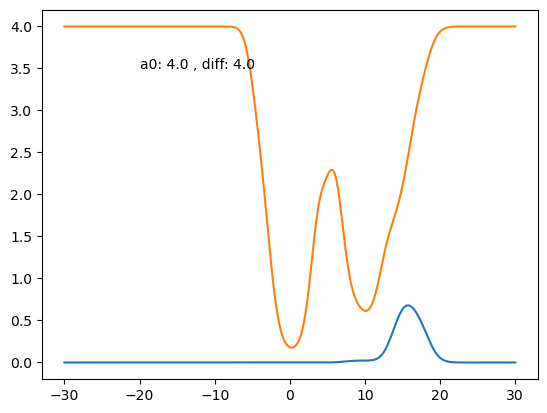

run  2  of  3 tf:  11.581
run  3  of  3 tf:  11.581


In [17]:
# euler method
# cannot use adaptive timesteps methods


w = 0.0
delta = 0.1


run_n = 3

sol_a0 = []

ratio = 0.5
for a0 in a0s:
    nu = ratio*a0
    sol_diff = []
    for diff in diffs: 
        print("diffusion coefficient:  ", diff)
        tf = 400.0

        v_run = []
        xp_run = []
        burnt_run = []
        eff_run = []

        for run in range(run_n):
            print("run ",run+1," of ", run_n,"tf: ", tf)
            # A0x = a0*ones(Nx) + 0.1*a0*2.0*(0.5-random.random(Nx))

            xp = 0.0
            As = zeros(Nx)
            As[xs > 0.0] = a0
            As = ones(Nx) *a0 # no build in asymmetry
            Ac = zeros(Nx)


            dt = 0.001
            t_max = int(tf/dt)
            xp_t = []
            eff_t = []
            v_t = []
            burnt_t = []


            for t in range(t_max): ## loop through for every time step
                ## first determine total force on hub
                eps = 1e-8
                jj = where(Ac < eps)[0] # check where Acx is very small (and log(Acx) will be a problem)
                Acx_temp = Ac.copy()    # make a temporary copy to change, so that Acx does not need to be changed
                Acx_temp[jj] =  1e-10     
                err = (log(eps)-log(Acx_temp))


                wr = zeros(Nx)
                ii = where(err < 0.0)[0]
                wr[ii] = w*Ac[ii]
                force_unbinding = wr * exp(abs(xp - xs) * delta)

                noise = sqrt(2*dt) * diff* random.normal(0.0,1.0)

                total_f = trapz(-(xp -xs) * Ac, x=xs) 
                binding = exp(-0.5 * (xp - xs) ** 2) * As
                burnt = nu * Ac
                Ac += (binding - burnt -force_unbinding) *dt
                As += (- binding + force_unbinding) * dt
                xp += total_f * dt + noise 
                xp_t.append(xp)
                v_t.append(total_f)
                burnrate = trapz(Ac,x= xs)*nu
                burnt_t.append(burnrate)
                eff_t.append(total_f**2/burnrate)

                if run == 0:
                    '''if t % 1000 == 0:
                        display.clear_output(wait=True)
                        #input("Press enter to continue")
                        cla()
                        plot(xs,Ac)
                        plot(xs,As)
                        text(-20,0.1,diff)
                        display.display(gcf())'''

                    if abs(xp) > length-10:
                        t_max = t+1
                        tf = t_max*dt
                        display.clear_output(wait=True)
                        cla()
                        plot(xs,Ac)
                        plot(xs,As)
                        text(-length+10.0,a0-0.5,"a0: " +str(a0) +" , diff: " +str(diff))
                        display.display(gcf())
                        #input("Press enter to continue")
                        break

            v_run.append(v_t)
            xp_run.append(xp_t)
            burnt_run.append(burnt_t)
            eff_run.append(eff_t)
        
        v_run = [mean(array(v_run), axis = 0), std(array(v_run), axis = 0)]           # just store the mean value for each time step throughout the runs
        xp_run = [mean(array(xp_run), axis = 0), std(array(v_run), axis = 0)]  
        burnt_run = [mean(array(burnt_run), axis = 0), std(array(v_run), axis = 0)]  
        eff_run = [mean(array(eff_run), axis = 0), std(array(v_run), axis = 0)]  
        
        sol_diff.append([v_run,xp_run,burnt_run,eff_run,t_max])
    sol_a0.append(sol_diff)
    





In [20]:
a0 = 0
diff = 0
back = int(sol_a0[a0][diff][-1]*0.1)
array(sol_a0[a0][diff][2][0][back:])
mean(array(sol_a0[a0][diff][2][0][back:]))
sqrt(mean((array(sol_a0[a0][diff][0][1][back:])**2)))

0.07000639431677459

In [19]:
# for average already calculated and stored
# plot efficiency for each run 

for a0 in range(a0_n):
    eff = zeros((diff_n,2))
    burn = zeros((diff_n,2))
    speed = zeros((diff_n,2))
    for diff in range(diff_n):
        back = int(sol_a0[a0][diff][-1]*0.1) #look at last 10% of trajectory
        
        burnave = mean(array(sol_a0[a0][diff][2][0][back:]))
        effave = mean(array(sol_a0[a0][diff][3][0][back:]))
        speedave = mean(array(sol_a0[a0][diff][0][0][back:]))
        
        burnstd = sqrt(mean((array(sol_a0[a0][diff][2][1][back:]))**2))
        effstd = sqrt(mean((array(sol_a0[a0][diff][3][1][back:])**2)))
        speedstd = sqrt(mean((array(sol_a0[a0][diff][0][1][back:])**2)))

        burn[diff,0],burn[diff,1] = burnave,burnstd 
        eff[diff,0],eff[diff,1] = effave,effstd
        speed[diff,0],speed[diff,1] = abs(speedave),speedstd
    errorbar(diffs,eff[:,0], yerr = eff[:,1], label = "$a_{tot}$: "+ str(a0s[a0])+r" $\nu'$: " +str(a0s[a0]*ratio))
    title("Relative efficiency for varying diffusion rates")
    xlabel("D'")
    ylabel(r"$\eta$")
    legend()

In [ ]:
# plot position vs. time 

for diff in range(diff_n):
    display.clear_output(wait=True)
    input("Press enter to continue")
    cla()
    
    t_max = sol_diff[diff][-1]
    tf = t_max*dt
    v_ave = zeros(t_max)
    for run in range(run_n):
        v = zeros(t_max)
        for t in range(t_max):
            v[t] = sol_diff[diff][run][1][t]
        v_ave += v/run_n
            
         
        plot(linspace(0,tf,t_max),v,"--")
        #plot(linspace(0,0.01,10),v[-10:],"--")
    plot(linspace(0,tf,t_max),v_ave,"b-", label = "average")
    #plot(linspace(0,0.01,10),v_ave[-10:],"b-", label = "average")
    xlabel("time")
    ylabel("position")
    legend()
    display.display(gcf())

In [ ]:
# plot efficiency for each run 
back = -100  
eff = []
burn = []
for diff in range(diff_n):
    burn_run = []
    eff_run = []
    for run in range(run_n):
        burnave = mean(array(sol_diff[diff][run][2][back:]))
        effave = mean(array(sol_diff[diff][run][3][back:]))
        burn_run.append(burnave)
        eff_run.append(effave)
       
    eff.append(mean(array(eff_run)))
    burn.append(mean(array(burn_run)))    

In [ ]:
plot(diffs,burn)
xlabel("diffusion constant")
ylabel("efficiency")
#xscale('log')
#legend()

0
1
2
3
4


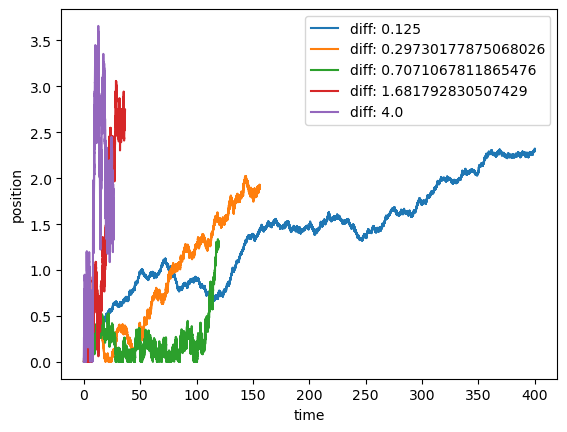

Press enter to continue


In [15]:
# for average already calculated and stored
# plot position vs. time 
for a0 in range(a0_n):
    display.clear_output(wait=True)
    cla()
    for diff in range(diff_n):
        print(diff)

        t_max = sol_a0[a0][diff][-1]
        tf = t_max*dt
        xp_ave = abs(sol_a0[a0][diff][1][0])

        
        
        
        
        plot(linspace(0,tf,t_max),xp_ave, label = "diff: "+str(diffs[diff]))
        #plot(linspace(0,0.01,10),v_ave[-10:],"b-", label = "average")
        xlabel("time")
        ylabel("position")  
        legend()
    display.display(gcf())
    input("Press enter to continue")